In [12]:
import dgl
import torch
from torch._C import device
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from dgl.data import MiniGCDataset
from dgl.nn.pytorch import GraphConv
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#### Data Process

In [13]:
class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()
        self.conv1 = GraphConv(in_dim, hidden_dim)  # 定义第一层图卷积
        self.conv2 = GraphConv(hidden_dim, hidden_dim)  # 定义第二层图卷积
        self.classify = nn.Linear(hidden_dim, n_classes)   # 定义分类器

    def forward(self, g):
        """g表示批处理后的大图,N表示大图的所有节点数量,n表示图的数量 
        """
        # 为方便，我们用节点的度作为初始节点特征。对于无向图，入度 = 出度
        h = g.in_degrees().view(-1, 1).float() # [N, 1]
        # 执行图卷积和激活函数
        h = F.relu(self.conv1(g, h))  # [N, hidden_dim]
        h = F.relu(self.conv2(g, h))  # [N, hidden_dim]
        g.ndata['h'] = h    # 将特征赋予到图的节点
        # 通过平均池化每个节点的表示得到图表示
        hg = dgl.mean_nodes(g, 'h')   # [n, hidden_dim]
        return self.classify(hg)  # [n, n_classes]

def collate(samples):
    # 输入参数samples是一个列表
    # 列表里的每个元素是图和标签对，如[(graph1, label1), (graph2, label2), ...]
    # zip(*samples)是解压操作，解压为[(graph1, graph2, ...), (label1, label2, ...)]
    graphs, labels = map(list, zip(*samples))
    # dgl.batch 将一批图看作是具有许多互不连接的组件构成的大型图
    return dgl.batch(graphs), torch.tensor(labels, dtype=torch.long)

In [14]:
# 创建训练集和测试集
trainset = MiniGCDataset(2000, 10, 100)  # 生成2000个图，每个图的最小节点数>=10, 最大节点数<=20
testset = MiniGCDataset(1000, 10, 100) 

In [15]:
print(type(testset))

<class 'dgl.data.minigc.MiniGCDataset'>


In [16]:
graph, label = trainset[500]
print(graph)
print(label)
print(graph.edges())
print(graph.nodes())

Graph(num_nodes=84, num_edges=416,
      ndata_schemes={}
      edata_schemes={})
tensor(2)
(tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  2,  3,
         3,  3,  4,  4,  4,  5,  5,  5,  6,  6,  6,  7,  7,  7,  8,  8,  8,  9,
         9,  9, 10, 10, 10, 11, 11, 11, 12, 12, 12, 13, 13, 13, 14, 14, 14, 15,
        15, 15, 16, 16, 16, 17, 17, 17, 18, 18, 18, 19, 19, 19, 20, 20, 20, 21,
        21, 21, 22, 22, 22, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 26, 27,
        27, 27, 28, 28, 28, 29, 29, 29, 30, 30, 30, 31, 31, 31, 32, 32, 32, 33,
        33, 33, 34, 34, 34, 35, 35, 35, 36, 36, 36, 37, 37, 37, 38, 38, 38, 39,
        39, 39, 40, 40, 40,

In [17]:
# 假设每个节点都有一个一维特征向量  
node_features = torch.randn((graph.number_of_nodes(), 25))  
graph.ndata['feat'] = node_features  
  
# 假设每条边都有一个一维特征向量  
edge_features = torch.randn((graph.number_of_edges(), 1))  
graph.edata['feat'] = edge_features

print('节点特征：')
print(graph.ndata['feat'].shape)
print(graph.ndata)

print('边权：')
print(graph.edata['feat'].shape)
print(graph.edata)

节点特征：
torch.Size([84, 25])
{'feat': tensor([[ 0.7760, -1.5698,  0.7699,  ...,  0.7469,  0.0904,  0.6225],
        [ 0.0964,  0.5544,  0.6456,  ..., -0.9286,  2.6449, -1.1710],
        [ 0.9453,  1.5207, -0.3070,  ...,  0.1178, -1.2003, -1.6691],
        ...,
        [ 0.9600,  0.5382, -0.4435,  ...,  0.1758, -0.3781,  0.0166],
        [ 0.5403,  0.0669, -0.8328,  ..., -0.2245, -1.1609, -1.0882],
        [ 0.6635,  0.7705,  0.8355,  ...,  1.5973,  0.8075,  0.6375]])}
边权：
torch.Size([416, 1])
{'feat': tensor([[ 2.5371e-01],
        [-3.6282e-01],
        [ 6.0054e-01],
        [ 1.0095e+00],
        [-2.0207e-01],
        [ 1.2768e-01],
        [-3.3000e-01],
        [-1.0773e-01],
        [-1.0002e+00],
        [-1.8148e+00],
        [ 2.2315e+00],
        [ 1.3356e+00],
        [-1.0865e+00],
        [ 1.9271e-01],
        [ 6.6456e-01],
        [-1.1203e+00],
        [ 1.6452e+00],
        [-1.1711e+00],
        [-7.8950e-01],
        [-6.0988e-02],
        [-3.3537e-01],
        [-8.

In [18]:
# 为训练集中的每个图添加特征  
for i in range(len(trainset)):  
    # 获取当前图的Data对象  
    graph_data, label = trainset[i]  
      
    # 添加25维节点特征，这里随机初始化  
    graph_data.ndata['feat'] = torch.randn((graph_data.num_nodes(), 25)) 
      
    # 添加1维边特征，这里随机初始化  
    graph_data.edata['feat'] = torch.randn((graph_data.num_edges(), 1))
  
# 为测试集中的每个图添加特征（同训练集）  
for i in range(len(testset)):  
    # 获取当前图的Data对象  
    graph_data, label = testset[i]  
      
    # 添加25维节点特征，这里随机初始化  
    graph_data.ndata['feat'] = torch.randn((graph_data.num_nodes(), 25)) 
      
    # 添加1维边特征，这里随机初始化  
    graph_data.edata['feat'] = torch.randn((graph_data.num_edges(), 1))

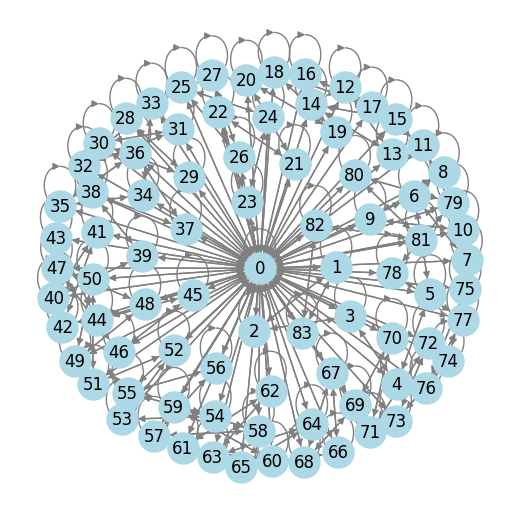

In [19]:
plt.figure(figsize = (5, 5))

nx_graph = graph.to_networkx()

# 为 NetworkX 图设置节点位置
pos = nx.kamada_kawai_layout(nx_graph)
# pos = nx.spring_layout(nx_graph)
# pos = nx.circular_layout(nx_graph)
# pos = nx.shell_layout(nx_graph)
# pos = nx.random_layout(nx_graph)
# pos = nx.spectral_layout(nx_graph)
# pos = nx.planar_layout(nx_graph)

# 绘制图形
nx.draw(nx_graph, pos, with_labels=True, node_size=500, node_color='lightblue', edge_color='gray')

# 显示图形
plt.show()

In [20]:
# def generate_connected_graph(num_nodes):
#     """
#     生成一个无向连通图，每个节点的度大于等于1。
    
#     参数:
#     num_nodes (int): 图中的节点数量。
    
#     返回:
#     nx.Graph: 生成的无向连通图。
#     """
#     # 创建一个无向图
#     graph = nx.Graph()
#     # 添加节点
#     for i in range(num_nodes):
#         graph.add_node(i)
#     # 添加边，确保图是连通的
#     for i in range(num_nodes):
#         for j in range(i + 1, num_nodes):
#             graph.add_edge(i, j)
#     return graph

# # 指定节点数量
# num_nodes = 20  # 例如，生成一个包含10个节点的无向连通图

# # 生成无向连通图
# connected_graph = generate_connected_graph(num_nodes)
# # 绘制图形
# pos = nx.spring_layout(connected_graph)  # 为图形设置节点位置
# nx.draw(connected_graph, pos, with_labels=True, node_size=500, node_color='lightblue', edge_color='gray')

# # 显示图形
# plt.show()

In [21]:
# 用pytorch的DataLoader和之前定义的collect函数
data_loader = DataLoader(trainset, batch_size=64, shuffle=True, collate_fn=collate)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 构造模型 
model = Classifier(1, 256, trainset.num_classes)
model.to(DEVICE)
print(model)

# 定义分类交叉熵损失
loss_func = nn.CrossEntropyLoss()
# 定义Adam优化器
optimizer = optim.Adam(model.parameters(), lr=0.001)

Classifier(
  (conv1): GraphConv(in=1, out=256, normalization=both, activation=None)
  (conv2): GraphConv(in=256, out=256, normalization=both, activation=None)
  (classify): Linear(in_features=256, out_features=8, bias=True)
)


In [22]:
# 创建DataLoader
collate_fn = lambda samples: dgl.batch([g for g, _ in samples])
train_loader = DataLoader(trainset, batch_size=64, shuffle=True, collate_fn=collate)
test_loader = DataLoader(testset, batch_size=64, shuffle=False, collate_fn=collate)

In [23]:
from scipy.sparse import coo_matrix

for idx, (batched_graph, labels) in enumerate(train_loader):
    if idx == 1:
        print("batched_graph:\n", batched_graph)
        print("labels:\n", labels)
        # 初始化一个全零矩阵
        adjacency_matrix_dense = torch.zeros(batched_graph.num_nodes(), batched_graph.num_nodes())

        # 填充邻接矩阵
        src, dst = batched_graph.edges()
        adjacency_matrix_dense[src, dst] = 1
        print(adjacency_matrix_dense.shape)
        # adjacency_matrix_scipy = coo_matrix((torch.ones(src.size(0)), (src.numpy(), dst.numpy())), shape=(batched_graph.num_nodes(), batched_graph.num_nodes()))
        break  # 打印第一个批次后退出循环

batched_graph:
 Graph(num_nodes=3162, num_edges=28544,
      ndata_schemes={'feat': Scheme(shape=(25,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)})
labels:
 tensor([7, 7, 7, 3, 0, 7, 6, 0, 3, 2, 0, 7, 1, 3, 5, 1, 2, 1, 6, 0, 6, 1, 2, 6,
        2, 5, 7, 7, 4, 1, 7, 1, 1, 1, 0, 4, 2, 7, 4, 2, 7, 5, 3, 5, 5, 4, 5, 3,
        3, 2, 7, 1, 3, 0, 0, 2, 4, 3, 7, 0, 7, 2, 5, 5])
torch.Size([3162, 3162])


In [24]:
import numpy as np
import os
np.set_printoptions(threshold=np.inf)

In [25]:
path = r'C:\Users\ChenXY\Desktop\VScode\Python\iGEM\Final_First\ScriptFiles\GCN\txtdata.txt'
os.makedirs(os.path.dirname(path), exist_ok=True)
with open(path, 'w') as file:
    for i in adjacency_matrix_dense:
        file.write(str((i.type(torch.int32).numpy()).reshape(-1).tolist()) + '\n')

In [26]:
# 模型训练
Epochs = 100
Epoch_losses = []
Acc = []
for epoch in range(Epochs): 
    model.train()
    epoch_loss = 0
    for iter, (batchg, label) in enumerate(data_loader):
        batchg, label = batchg.to(DEVICE), label.to(DEVICE)
        prediction = model(batchg)
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
    epoch_loss /= (iter + 1)
    print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss), end = '    ')
    Epoch_losses.append(epoch_loss)
    
    model.eval()
    test_pred, test_label = [], []
    with torch.no_grad():
        for it, (batchg, label) in enumerate(test_loader):
            batchg, label = batchg.to(DEVICE), label.to(DEVICE)
            pred = torch.softmax(model(batchg), 1)
            pred = torch.max(pred, 1)[1].view(-1)
            test_pred += pred.detach().cpu().numpy().tolist()
            test_label += label.cpu().numpy().tolist()
    acc = accuracy_score(test_label, test_pred)
    print('Acc {:.4f}({:.2f}%)'.format(acc, 100*acc))
    Acc.append(acc)
    

Epoch 0, loss 1.9172    Acc 0.1530(15.30%)
Epoch 1, loss 1.8320    Acc 0.1460(14.60%)
Epoch 2, loss 1.8021    Acc 0.1540(15.40%)
Epoch 3, loss 1.7128    Acc 0.4640(46.40%)
Epoch 4, loss 1.5742    Acc 0.5420(54.20%)
Epoch 5, loss 1.3668    Acc 0.5090(50.90%)
Epoch 6, loss 1.2283    Acc 0.5430(54.30%)
Epoch 7, loss 1.0642    Acc 0.5590(55.90%)
Epoch 8, loss 0.9497    Acc 0.6610(66.10%)
Epoch 9, loss 0.8696    Acc 0.6610(66.10%)
Epoch 10, loss 0.8313    Acc 0.5970(59.70%)
Epoch 11, loss 0.7983    Acc 0.6240(62.40%)
Epoch 12, loss 0.7746    Acc 0.6420(64.20%)
Epoch 13, loss 0.7637    Acc 0.7230(72.30%)
Epoch 14, loss 0.7369    Acc 0.6150(61.50%)
Epoch 15, loss 0.7297    Acc 0.6980(69.80%)
Epoch 16, loss 0.7141    Acc 0.6730(67.30%)
Epoch 17, loss 0.7100    Acc 0.6300(63.00%)
Epoch 18, loss 0.7020    Acc 0.7080(70.80%)
Epoch 19, loss 0.7083    Acc 0.7360(73.60%)
Epoch 20, loss 0.6998    Acc 0.7290(72.90%)
Epoch 21, loss 0.6699    Acc 0.6870(68.70%)
Epoch 22, loss 0.6603    Acc 0.6410(64.10%

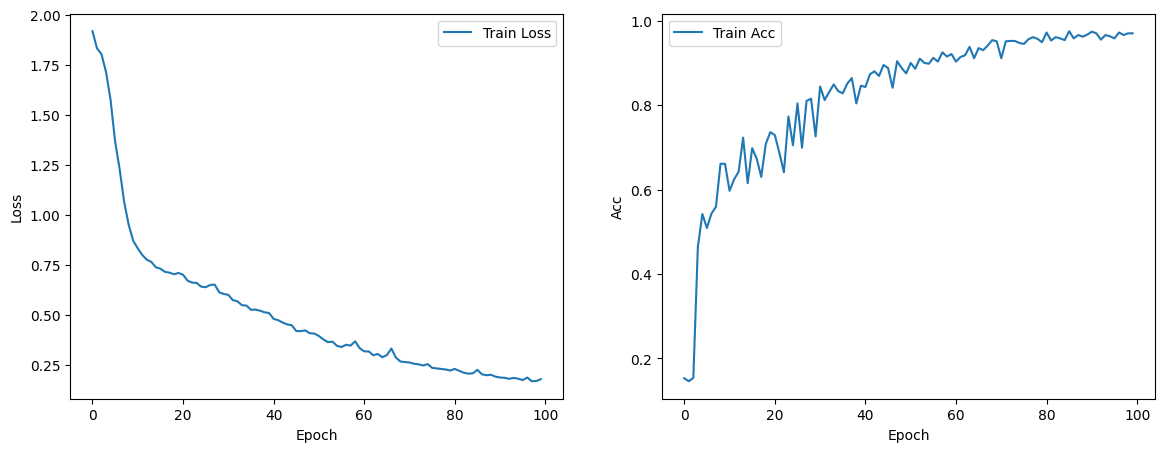

In [27]:
plt.figure(figsize = (14, 5))
plt.subplot(1, 2, 1)
plt.plot(Epoch_losses, label = 'Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Acc, label = 'Train Acc')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [28]:
# 测试
model.eval()
test_pred, test_label = [], []
with torch.no_grad():
    for it, (batchg, label) in enumerate(test_loader):
        batchg, label = batchg.to(DEVICE), label.to(DEVICE)
        pred = torch.softmax(model(batchg), 1)
        pred = torch.max(pred, 1)[1].view(-1)
        test_pred += pred.detach().cpu().numpy().tolist()
        test_label += label.cpu().numpy().tolist()
Test_Acc = accuracy_score(test_label, test_pred)
print("Test accuracy: ", Test_Acc)

Test accuracy:  0.97


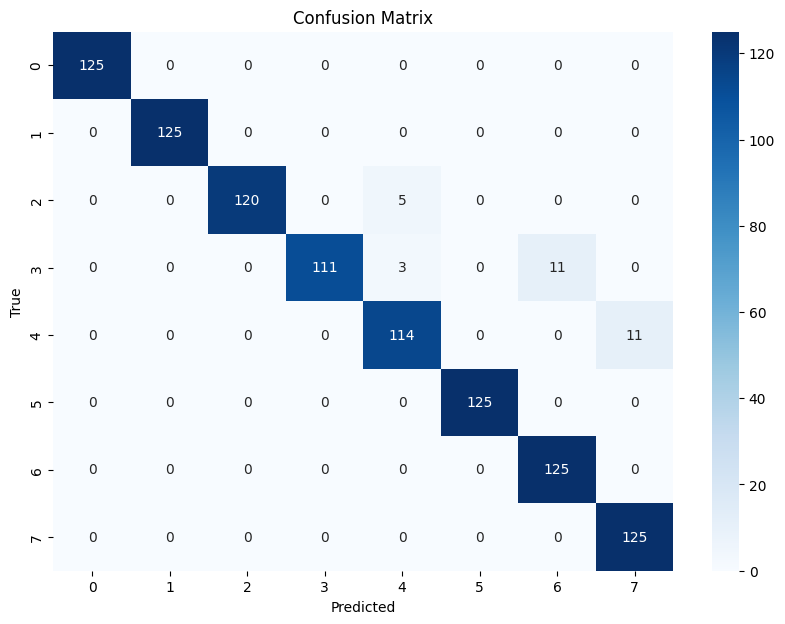

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       125
           1       1.00      1.00      1.00       125
           2       1.00      0.96      0.98       125
           3       1.00      0.89      0.94       125
           4       0.93      0.91      0.92       125
           5       1.00      1.00      1.00       125
           6       0.92      1.00      0.96       125
           7       0.92      1.00      0.96       125

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



In [29]:

# 生成混淆矩阵
cm = confusion_matrix(test_label, test_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 生成分类报告
report = classification_report(test_label, test_pred)
print(report)